# Foundation of Machine Learning  (Project)
### Student: Stefano di Lena



# Recommender System
Usando:
1. collaborative filtering;
2. content-based filtering.

Dataset: [MovieLens](https://grouplens.org/datasets/movielens/)


## 1: Importare i Pacchetti necessari


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2: Caricare i Dati


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# percorso dei file:
ratings_path = '/content/drive/MyDrive/ProgettoML/Dataset/ratings.csv'
movies_path = '/content/drive/MyDrive/ProgettoML/Dataset/movies.csv'

# caricamento dei dati
ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)


Mounted at /content/drive


### Check
Visualizzo le prime 5 righe dei dataset appena caricati

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## 3: Esplorare il Dataset

In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")

print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.37


### Distribuzione

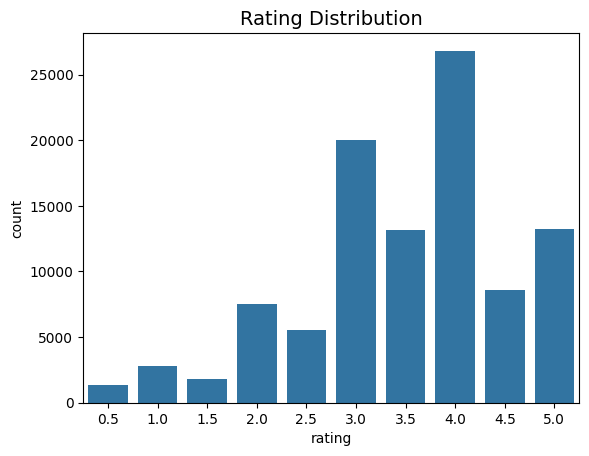

In [ ]:
sns.countplot(x='rating', data=ratings)
plt.title('Rating Distribution', fontsize=14)
plt.show()

In [ ]:
print(f"Mean global rating: {round(ratings['rating'].mean(), 2)}")

Mean global rating: 3.5


In [ ]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(), 2)}")

Mean rating per user: 3.66


### Film frequentementente votati

In [ ]:
# unisco il nome dei film al numero di recensioni
movie_ratings = ratings.merge(movies, on='movieId')
# stampo le prime dieci righe
movie_ratings['title'].value_counts()[0:10]

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


*Forrest Gump*, *The Shawshank Redemption* e *Pulp Fiction* hanno più votazioni.

In [ ]:
movie_ratings['title'].value_counts().tail(10)

,count
title,
Love (2015),1
The Lost Room (2006),1
Tangerine (2015),1
Chasuke's Journey (2015),1
How To Change The World (2015),1
"Sex, Drugs & Taxation (2013)",1
Extraordinary Tales (2015),1
Tomorrow (2015),1
Embrace of the Serpent (2016),1


Questi sono invece i 10 film meno votati.

### Quali sono i film con il miglior e peggior voto?

In [ ]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


*Gypsy* ha il peggior voto

In [ ]:
ratings[ratings['movieId']==lowest_rated]

,userId,movieId,rating,timestamp
13633,89,3604,0.5,1520408880


(voto: 0.5) ma ha una sola recensione.

In [ ]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


*Lamerica* ha la migliore votazione

In [ ]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


(voto: 5.0) ma con due sole recensioni

#### Bayesian Average
$r_i = \frac{Cm + \sum_{i=1}^n x_i}{C+n}$

Dove *C* rappresenta il numero medio di voti per un determinato titolo (confidenza), *m* lo score medio tra tutti i film (media a priori), $x_i$ le recensioni, *n* il numero di voti per l'i-esimo titolo

In [ ]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


Otteniamo quindi per ogni film il **count** (quante voti ha ottenuto) e **mean** (la votazione media per quel titolo).

In [ ]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


Proviamo la funziona **bayesian_avg** sul film *Lamerica*

In [ ]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.543

Otteniamo una votazione nettamente inferiore al 5.0 ottenuta precedentemente.

\\

Applico adesso la media bayesiaa a tutti i film nel dataset:

In [ ]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index() # reset_index() lo metto per trasformare una lista in un dataframe
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId') # ha il movieId, numero di recensioni, media dei voti e media bayesiana

In [ ]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']]) # agiungiamoil titolo a movie_statis creato prima
movie_stats.sort_values('bayesian_avg', ascending=False).head() # stampo le prime cinque righe ordinate per media bayesiana (dalla più alta alla più bassa)

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


Quindi *The Shanwshank Redemption* (Le ali della libertà) è il film con la votazione più alta.

In [ ]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


Mentre *Speed 2* risulta uno dei peggiori film, secondo la media Bayesiana. Quindi *Gypsy* non è detto che sia un pessimo film.

### Genere di Film
I **generi** sono presi da un'unica stringa. Questi sono separati l'uno dall'altro attraverso una pipe `|`. Possiamo manipolare questa stringa in una lista per semplificare l'analisi.

\\

Alla fine di ogni **titolo** c'è l'anno di uscita tra parentesi tonde. Possiamo estrarlo da ogni film e creare una nuova colonna **year**.

\\

In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


Per sapere quanti genere di film sono presenti nel dataset è possibile usare la funzionde *Counter* di Python.

In [ ]:
from collections import Counter
tot_genre = Counter([g for genres in movies['genres'] for g in genres])

print(f"Ci sono in totale {len(tot_genre)} genere di film.")

tot_genre

Ci sono in totale 20 genere di film.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [ ]:
print("I 5 generi più comuni sono: \n", tot_genre.most_common(5))

I 5 generi più comuni sono: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


Per visualizzarli con un barplot:

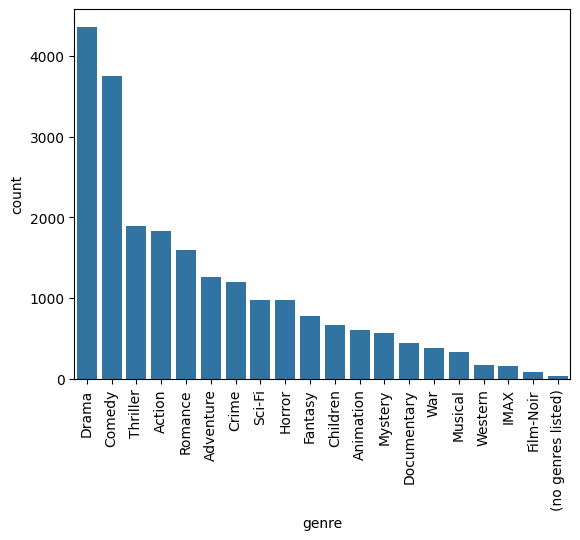

In [ ]:
genre_frequency_df = pd.DataFrame([tot_genre]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90) # per migliorare la lettura dei generi ruoto di 90 gradi
plt.show()

## 4: Pre-processing dei Dati
Per generare le raccomandazioni uso la tecnica del colaborative filtering. Questa tecnica si basa sul fatto che ad utenti simili possano piacere le stesse cose.

\\

Per prima cosa bisogna trasformare i dati in una matrice *user-item* (conosciuta come **utility** matrix). Per questo dataset le righe rappresenteranno gli utenti e le colonne i vari film.  


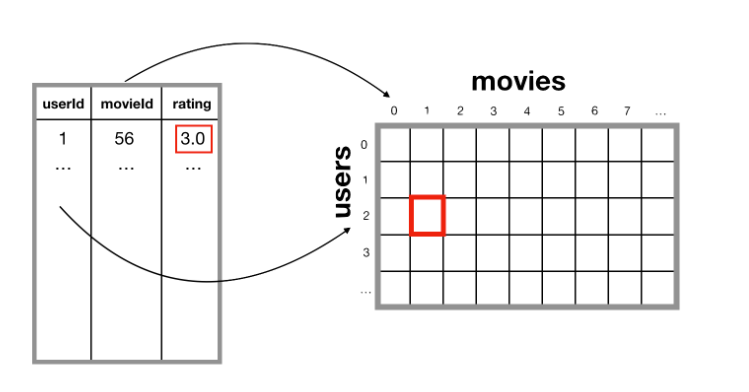

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Genera una matrice sparsa dal ratings dataframe.

    Args:
        df: pandas dataframe contenente 3 colonne (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

La **X** (matrice user-item) è una [scipy.sparse.crs_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) che memorizza i dati in modo sparso.

In [ ]:
X.shape

(610, 9724)

La matrice **X**, quindi, contiene 610 utenti e 9724 film.

### Valutare la sparsità
Possiamo calcolarla come il numero di elementi memorizzati fratto il numero totale di elementi.

\\

Il numero di elementi memorizzati nella matrice ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) è uguale al numero di ratings nel dataset.

In [ ]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz # conta i valori memorizzati nella matrice sparsa, le restanti celle sono vuote
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


Il **cold start problem** si ha quando ci suono nuovi utenti e film nella matrice e non abbiamo nessuna recensione. Nel MovieLens dataset tutti gli utenti hanno almeno una votazione, ma è utile verificare quali utenti e film hanno meno interazioni.

In [ ]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [ ]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [ ]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [ ]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


## 5: Raccomandazioni item-item usando il KNN (K-Nearest Neighbors)

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_movies()` prende un `MovieId` e la matrice `X` in input, e restituisce un elenco di *k* film simili al `MovieId` di interesse in output.






In [ ]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

Converto `MovieId` in `title` creando un dizionario.



In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


In output notiamo 9 film simili a *Toy Story*. Queste raccomandazioni si basano solamente sugli user-item ratings.

\\

Si potrebbe usare una metrica differente da *'cosine'*, ad esempio *'euclidean'* o altre presnti [qui](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html).

In [ ]:
#movie_id = 1

#similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
#movie_title = movie_titles[movie_id]

#print(f"Because you watched {movie_title}:")
#for i in similar_movies:
#    print(movie_titles[i])

## 6: Cold-Start Problem

Per gestire questo problema possiamo usare il content-based filtering.

\\

Per prima cosa bisogna convertire la colonna **genres** in features binarie. Ogni genere avrà la propria colonna nel dataframe, formata da 0 o 1.

In [ ]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [ ]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [ ]:
movie_genres.head()

,Animation,Western,Film-Noir,Romance,Crime,(no genres listed),Children,Adventure,Action,Comedy,Fantasy,Sci-Fi,Thriller,Documentary,War,Musical,Drama,IMAX,Horror,Mystery
0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


Come aspettato, passando il dataframe **movie_genres** alla funzione *cosine_similarity()* otteniamo una matrice di dimensione: \\
 ($n_{film}, n_{film}$).

\\

Questa matrice è formata solo da zeri ed uni che rappresentano il grado di somiglianza tra i film lungo gli assi *x* ed *y*.

### Creare una funzione di ricerca film
Può essere utile perché altrimenti dobbiamo conoscere il nome esatto con cui è listato un film nel dataset e nel nostro caso anche l'anno in cui è uscito. Se sbagliamo a scrivere un titolo per un errore di grammatica o dimentichiamo di mettere la data di uscita, il raccomandatore non è in grado di identificare il fim che ci interessa.

Per implementare ciò possiamo usare il package [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/), che permette di trovare il titolo più simile alla stringa passata in input.

In [ ]:
!pip install fuzzywuzzy
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Test della funzione **movie_finder()**, cercando Jumanji con errori di spelling.

In [ ]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

Per ottenere anche i suggerimenti collegati al film *Jumanji* abbiamo bisogno di sapere il suo indice nella cosine similarity matrix.

\\

Creo quindi un dizionario: **movie_idx** che ha come chiave i titoli dei film e come valori gli indici degli stessi.

In [ ]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


Quindi *Jumanji* è rappresentato dall'index 1 nella nostra matrice.

Per ottenere i 10 film più simili a *Jumanji*:

In [ ]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

Quindi, **similar_movies** è un array di indici che rappresenta le 10 raccomandazioni migliori relative al film *Jumanji*. Possiamo ottenere poi i titoli relativi a questi suggerimenti attraverso `.iloc()`  sulla colonna dei titoli del dataframe movies.




In [ ]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


,title
53,"Indian in the Cupboard, The (1995)"
109,"NeverEnding Story III, The (1994)"
767,Escape to Witch Mountain (1975)
1514,Darby O'Gill and the Little People (1959)
1556,Return to Oz (1985)
1617,"NeverEnding Story, The (1984)"
1618,"NeverEnding Story II: The Next Chapter, The (1..."
1799,Santa Claus: The Movie (1985)
3574,Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075,"Chronicles of Narnia: The Lion, the Witch and ..."


Per testare in maniera più semplice il sistema di raccomandazione con altri titoli di film, creo una ingola funzione che prende il titolo del film ed il numero di raccomandazioni volute.

In [ ]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [s for s in sim_scores if s[0] != idx]   # Escludo il film stesso
    sim_scores = sim_scores[:(n_recommendations)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Siccome hai visto {title}:")
    print(movies['title'].iloc[similar_movies])

In [ ]:
get_content_based_recommendations('reservoir dogs')

Siccome hai visto Reservoir Dogs (1992):
46                        Usual Suspects, The (1995)
826                         Dial M for Murder (1954)
831                            Basic Instinct (1992)
1250                               Switchback (1997)
1945                                Following (1998)
3329                                  Frantic (1988)
3991                               Red Dragon (2002)
5294         Sherlock Holmes: Terror by Night (1946)
5296    Sherlock Holmes and the Secret Weapon (1942)
5337             Murder on the Orient Express (1974)
6846                           Righteous Kill (2008)
Name: title, dtype: object


In [ ]:
get_content_based_recommendations('toy stroy', 5)

Siccome hai visto Toy Story (1995):
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object


### References

[1] [Jill Cates](https://www.youtube.com/watch?v=v_mONWiFv0k) \\
[2] [Google Developers](https://developers.google.com/machine-learning/recommendation/collaborative/basics) : Machine Learning > Advanced courses > Collaborative filtering